In [86]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import re

# Nutrition


In [47]:
df = pd.read_csv('../data/myfitnesspal/raw/mfp_nutrition_raw.csv')
print("** First glimpse at column structure")
print(df.head())
print("** Data Frame size and structure")
print(df.shape)
print("** Column names/headers")
print(df.columns)
print("** First glimpse at column structure")
print(df.info())
print("** Basic Info/stats")
print(df.describe())
print("** Checking for nulls")
print(df.isnull().sum())

** First glimpse at column structure
         Date       Meal  Calories  Fat (g)  Saturated Fat  \
0  2024-02-28      Lunch     530.7     19.8            3.2   
1  2024-02-29     Dinner      47.4      2.0            1.3   
2  2024-03-01  Breakfast     195.0     10.8            6.9   
3  2024-03-01      Lunch     576.9     34.1            7.5   
4  2024-03-02     Dinner     652.0     30.4           14.2   

   Polyunsaturated Fat  Monounsaturated Fat  Trans Fat  Cholesterol  \
0                  0.8                  3.7        0.0         20.0   
1                  0.0                  0.0        0.0          0.0   
2                  0.0                  0.0        0.0          0.0   
3                  6.5                 17.9        0.0        159.8   
4                  3.0                  9.7        0.0          9.0   

   Sodium (mg)  Potassium  Carbohydrates (g)  Fiber  Sugar  Protein (g)  \
0       1021.8      595.6               56.1    4.8    5.8         31.6   
1          7.

# Creating flags to better understand the data


In [48]:
# Creating column flags for potential anomalies or guess-timates
# User knows of instances of creating 'fudged' inputs or data, highlighting now for ease of ignoring later on

df['zero_calorie'] = df['Calories'] < 1
df['zero_protein'] = df['Protein (g)'] < 1
df['zero_carbs'] = df['Carbohydrates (g)'] < 1
df['zero_fats'] = df['Fat (g)'] < 1





## Macro : Calorie discrepancies


In [49]:
# Using knowledge of macro-calorie relationships, flagging rows where calories:macro relationship is incorrect or unreliable
macros_to_calories = ((df['Protein (g)'] * 4) + (df['Carbohydrates (g)'] * 4) + (df['Fat (g)'] * 9))
df['cal_macro_discrepancy'] = df['Calories'] - macros_to_calories
df['macro_pct_diff'] = abs(df['cal_macro_discrepancy']) / df['Calories']
# Using a variation of 20% as a buffer for anomalies and data 'fudging'
df['macro_mismatch'] = df['macro_pct_diff'] > 0.10

print(df.head())
df['macro_mismatch'].value_counts()
df[df['macro_mismatch']].sort_values('macro_pct_diff', ascending=False).head()


         Date       Meal  Calories  Fat (g)  Saturated Fat  \
0  2024-02-28      Lunch     530.7     19.8            3.2   
1  2024-02-29     Dinner      47.4      2.0            1.3   
2  2024-03-01  Breakfast     195.0     10.8            6.9   
3  2024-03-01      Lunch     576.9     34.1            7.5   
4  2024-03-02     Dinner     652.0     30.4           14.2   

   Polyunsaturated Fat  Monounsaturated Fat  Trans Fat  Cholesterol  \
0                  0.8                  3.7        0.0         20.0   
1                  0.0                  0.0        0.0          0.0   
2                  0.0                  0.0        0.0          0.0   
3                  6.5                 17.9        0.0        159.8   
4                  3.0                  9.7        0.0          9.0   

   Sodium (mg)  ...  Calcium  Iron  Note  zero_calorie  zero_protein  \
0       1021.8  ...      7.0   5.2   NaN         False         False   
1          7.8  ...      0.0   0.0   NaN         False  

,Date,Meal,Calories,Fat (g),Saturated Fat,Polyunsaturated Fat,Monounsaturated Fat,Trans Fat,Cholesterol,Sodium (mg),...,Calcium,Iron,Note,zero_calorie,zero_protein,zero_carbs,zero_fats,cal_macro_discrepancy,macro_pct_diff,macro_mismatch
7,2024-03-07,Lunch,232.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,False,True,True,True,232.5,1.0,True
172,2024-07-09,Snacks,430.0,0.0,0.0,0.0,0.0,0.0,0.0,2.4,...,0.0,0.0,NaN,False,True,True,True,430.0,1.0,True
534,2024-12-21,Snacks,970.2,0.0,0.0,0.0,0.0,0.0,0.0,4.2,...,0.0,0.9,NaN,False,True,True,True,970.2,1.0,True
581,2025-01-11,Snacks,401.6,0.0,0.0,0.0,0.0,0.0,0.0,1.8,...,0.0,0.4,NaN,False,True,True,True,401.6,1.0,True
1163,2025-06-13,Snacks,194.0,0.0,0.0,0.0,0.0,0.0,0.0,0.8,...,0.0,0.2,NaN,False,True,True,True,194.0,1.0,True


## Meals which are probably just alcohol


In [50]:
# Zero carb, fat, protein, but calories indicates these entries could be alcohol: adding flag for when a meal seems to be alcohol (I was 25 we will allow it) 
df['likely_alcohol'] = (
    (df['Calories'] > 0) &
    (df['Protein (g)'] < 0.5) &
    (df['Carbohydrates (g)'] < 0.5) &
    (df['Fat (g)'] < 0.5)
)
print(df[df['likely_alcohol'] == True])

            Date    Meal  Calories  Fat (g)  Saturated Fat  \
7     2024-03-07   Lunch     232.5      0.0            0.0   
172   2024-07-09  Snacks     430.0      0.0            0.0   
534   2024-12-21  Snacks     970.2      0.0            0.0   
581   2025-01-11  Snacks     401.6      0.0            0.0   
600   2025-01-16  Snacks     291.1      0.0            0.0   
942   2025-04-14  Snacks     172.0      0.0            0.0   
1028  2025-05-09  Snacks     485.0      0.0            0.0   
1163  2025-06-13  Snacks     194.0      0.0            0.0   

      Polyunsaturated Fat  Monounsaturated Fat  Trans Fat  Cholesterol  \
7                     0.0                  0.0        0.0          0.0   
172                   0.0                  0.0        0.0          0.0   
534                   0.0                  0.0        0.0          0.0   
581                   0.0                  0.0        0.0          0.0   
600                   0.0                  0.0        0.0          0.0 

## Quantifying flags impact and reassessing


0.0985797827903091
0.006683375104427736
                 count        mean         std    min      25%     50%  \
likely_alcohol                                                           
False           1189.0  419.469722  276.667471   13.0  160.000  436.10   
True               8.0  397.050000  258.435247  172.0  222.875  346.35   

                   75%     max  
likely_alcohol                  
False           565.00  2372.6  
True            443.75   970.2  
                 count        mean         std   min      25%    50%      75%  \
macro_mismatch                                                                  
False           1079.0  396.298517  233.271249  13.0  158.400  428.3  549.850   
True             118.0  629.828814  479.904343  14.0  243.375  495.1  886.775   

                   max  
macro_mismatch          
False           1571.5  
True            2372.6  


<Axes: xlabel='Date'>

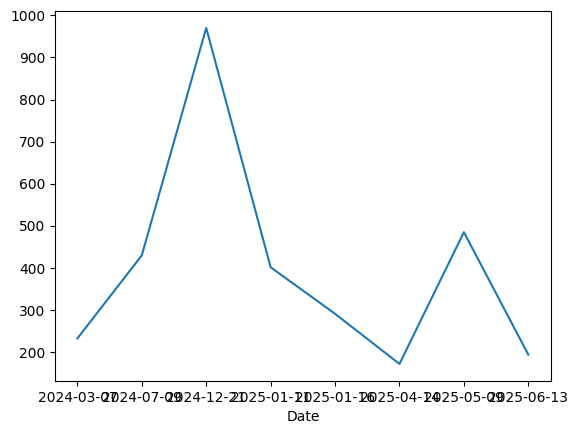

In [51]:
# Interested in keeping meals where it is assumed they are just alcohol, to match to behaviour trends later on. 
# Estimated alcohol based on the assumption of alcohol generally being 7 calories per gram
df['Estimated Alcohol (g)'] = df['likely_alcohol'] * (df['Calories'] / 7)


print(df['macro_mismatch'].mean())
print(df['likely_alcohol'].mean())

print(df.groupby('likely_alcohol')['Calories'].describe())
print(df.groupby('macro_mismatch')['Calories'].describe())

df[df['likely_alcohol']].groupby('Date')['Calories'].sum().plot()

## Adding a flag to identify which days are incomplete or not reflective to a daily total


In [52]:
all_meals = df.groupby('Date')['Meal'].apply(set).reset_index()
# print(all_meals)

all_meals['breakfast_inc'] = all_meals['Meal'].apply(lambda x: 'Breakfast' in x)
all_meals['lunch_inc'] = all_meals['Meal'].apply(lambda x: 'Lunch' in x)
all_meals['dinner_inc'] = all_meals['Meal'].apply(lambda x: 'Dinner' in x)

all_meals['missing_main_meal'] = ~(all_meals['breakfast_inc'] & all_meals['lunch_inc'] & all_meals['dinner_inc'])
print(all_meals)

df = df.merge(all_meals[['Date','missing_main_meal']], on='Date', how='left')

print(df)



           Date                                Meal  breakfast_inc  lunch_inc  \
0    2024-02-28                             {Lunch}          False       True   
1    2024-02-29                            {Dinner}          False      False   
2    2024-03-01                  {Breakfast, Lunch}           True       True   
3    2024-03-02                     {Lunch, Dinner}          False       True   
4    2024-03-07                  {Breakfast, Lunch}           True       True   
..          ...                                 ...            ...        ...   
336  2025-06-26  {Snacks, Breakfast, Lunch, Dinner}           True       True   
337  2025-06-27  {Snacks, Breakfast, Lunch, Dinner}           True       True   
338  2025-06-28  {Snacks, Breakfast, Lunch, Dinner}           True       True   
339  2025-06-29  {Snacks, Breakfast, Lunch, Dinner}           True       True   
340  2025-06-30          {Snacks, Breakfast, Lunch}           True       True   

     dinner_inc  missing_ma

In [ ]:
print(df[(df['macro_mismatch'] == True) & (df['likely_alcohol'] == False)])
df_cleaned = df[~((df['macro_mismatch'] == True) & (df['likely_alcohol'] == False))]



df_cleaned.to_csv('../data/myfitnesspal/cleaned/mfp_nutrition_cleaned.csv', index=False)

            Date    Meal  Calories  Fat (g)  Saturated Fat  \
12    2024-03-19   Lunch      87.0      0.2            0.0   
36    2024-06-04  Snacks     240.0      1.2            0.2   
51    2024-06-08  Snacks    1402.8      0.8            0.0   
77    2024-06-15  Dinner    1131.2     37.9            4.8   
78    2024-06-15   Lunch     452.8      0.2            0.0   
...          ...     ...       ...      ...            ...   
1141  2025-06-07  Snacks      44.0      0.5            0.1   
1169  2025-06-23  Snacks     127.6      3.5            0.5   
1185  2025-06-27  Snacks      83.0      0.0            0.0   
1187  2025-06-28  Dinner    1000.0     60.0           20.0   
1189  2025-06-28  Snacks    1413.2      0.0            0.0   

      Polyunsaturated Fat  Monounsaturated Fat  Trans Fat  Cholesterol  \
12                    0.0                  0.0        0.0          0.0   
36                    0.4                  0.2        0.0          0.0   
51                    0.1        

# Daily nutrition simplified, pivotting


In [54]:
df = pd.read_csv('../data/myfitnesspal/cleaned/mfp_nutrition_cleaned.csv')
print(df)

daily_overview = df.groupby('Date', as_index=False).agg({
    'Calories': 'sum',
    'Protein (g)': 'sum',
    'Carbohydrates (g)': 'sum',
    'Fat (g)': 'sum',
    'Estimated Alcohol (g)' : 'sum',
    'missing_main_meal' : 'max',
    'Meal': 'nunique'  # optional: helps check number of meals logged per day
})

print(daily_overview)
daily_overview.to_csv('../data/myfitnesspal/cleaned/mfp_nutrition_daily.csv', index=False)


            Date       Meal  Calories  Fat (g)  Saturated Fat  \
0     2024-02-28      Lunch     530.7     19.8            3.2   
1     2024-02-29     Dinner      47.4      2.0            1.3   
2     2024-03-01  Breakfast     195.0     10.8            6.9   
3     2024-03-01      Lunch     576.9     34.1            7.5   
4     2024-03-02     Dinner     652.0     30.4           14.2   
...          ...        ...       ...      ...            ...   
1082  2025-06-29      Lunch     449.6     19.9            6.4   
1083  2025-06-29     Snacks     155.0     10.0            8.3   
1084  2025-06-30  Breakfast     229.4     12.1            6.5   
1085  2025-06-30      Lunch     585.4     31.4            5.2   
1086  2025-06-30     Snacks      50.0      3.0            1.5   

      Polyunsaturated Fat  Monounsaturated Fat  Trans Fat  Cholesterol  \
0                     0.8                  3.7        0.0         20.0   
1                     0.0                  0.0        0.0          0.0 

# Measurements mfp


** First glimpse at column structure
         Date  Fitbit steps  Weight
0  2024-02-26           NaN    96.6
1  2024-02-27           NaN    96.6
2  2024-03-01           NaN    95.5
3  2024-03-06           NaN    93.8
4  2024-03-19           NaN    93.6
** Data Frame size and structure
(245, 3)
** Column names/headers
Index(['Date', 'Fitbit steps', 'Weight'], dtype='object')
** First glimpse at column structure
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245 entries, 0 to 244
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          245 non-null    object 
 1   Fitbit steps  144 non-null    float64
 2   Weight        209 non-null    float64
dtypes: float64(2), object(1)
memory usage: 5.9+ KB
None
** Basic Info/stats
       Fitbit steps      Weight
count         144.0  209.000000
mean            0.0   77.430622
std             0.0    7.101193
min             0.0   67.100000
25%             0.0   72.20000

<Axes: >

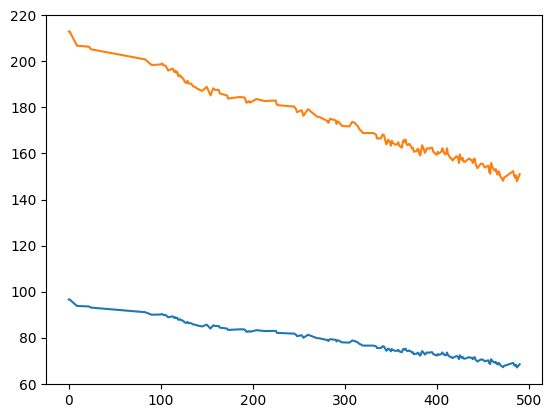

In [119]:
df = pd.read_csv('../data/myfitnesspal/raw/mfp_measurements_raw.csv')
print("** First glimpse at column structure")
print(df.head())
print("** Data Frame size and structure")
print(df.shape)
print("** Column names/headers")
print(df.columns)
print("** First glimpse at column structure")
print(df.info())
print("** Basic Info/stats")
print(df.describe())
print("** Checking for nulls")
print(df.isnull().sum())

# Not interested in monitoring 'fitbit steps' as this will be added from Apple Health data later on
df = df.drop(['Fitbit steps'],axis=1)

# Not interested in monitoring 'fitbit steps' as this will be added from Apple Health data later on

print(df)
print(df.duplicated().sum())
print(df.isna().sum())

df = df.dropna(subset=['Weight'])
print(df.head())

df['Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')
df = df.set_index('Date')
df = df.resample('D').asfreq()

# Choosing to interpolate missing values, assuming a linear weight change when weight wasnt recorded
df['Weight'] = df['Weight'].interpolate(method='linear')

# print(df)
df['Daily_change'] = df['Weight'].diff()
# print(df)

# Weekly measurements
# df = df.set_index('Date')


weekly_df = df.resample('W').agg(
    {'Weight': 'mean'
     }
).rename(columns={
    'Weight': 'weekly_avg_weight'
}).reset_index()
print(weekly_df)

weekly_df['weekly_loss'] = weekly_df['weekly_avg_weight'].diff()
print(weekly_df)


df = df.reset_index()
df = pd.merge(df.sort_values('Date'), weekly_df.sort_values('Date'),on='Date',how='left')
print(df.head(21))


df['Weight lbs'] = df['Weight'] * 2.2046226218
df['Daily_change lbs'] = df['Daily_change'] * 2.2046226218
df['weekly_avg_weight lbs'] = df['weekly_avg_weight'] * 2.2046226218
df['weekly_loss lbs'] = df['weekly_loss'] * 2.2046226218


print(df)
df.to_csv('../data/myfitnesspal/cleaned/mfp_measurements_cleaned.csv', index=False)
df['Weight'].plot()
df['Weight lbs'].plot()

# Measurements Active Era (smart scales)


** First glimpse at column structure
                Date  Weight   BMI Body Fat Subcutaneous Fat Heart Rate  \
0  07:37 Jul.02 2025  67.5kg  24.8    33.9%            24.2%     106bpm   
1  07:36 Jul.01 2025  68.0kg  25.0    33.9%            24.2%     104bpm   
2  08:33 Jun.30 2025  68.3kg  25.1    34.2%            24.4%     105bpm   
3  08:32 Jun.27 2025  67.1kg  24.6    33.9%            24.2%     118bpm   
4  07:42 Jun.27 2025  67.3kg  24.7    33.8%            24.1%     116bpm   

  Heart Index Visceral Fat Body Water Skeletal Muscle Muscle Mass Bone Mass  \
0  4.3L/Min/㎡          5.5      47.5%           36.0%      41.4kg     3.2kg   
1  4.2L/Min/㎡          5.5      47.6%           36.5%      41.9kg     3.1kg   
2  4.3L/Min/㎡          6.0      47.5%           36.2%      41.8kg     3.1kg   
3  4.8L/Min/㎡          5.5      47.4%           35.5%      41.0kg     3.3kg   
4  4.7L/Min/㎡          5.5      47.6%           36.0%      41.4kg     3.2kg   

  Protein       BMR Body Age  
0   13

<Axes: xlabel='Date'>

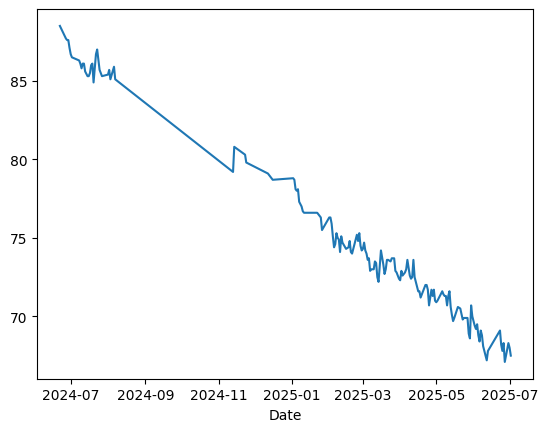

In [113]:
df = pd.read_csv('../data/myfitnesspal/raw/Active Era-Jessie_raw.csv')
df = df.drop('Unnamed: 15', axis=1)

print("** First glimpse at column structure")
print(df.head())
print("** Data Frame size and structure")
print(df.shape)
print("** Column names/headers")
print(df.columns)
print("** First glimpse at column structure")
print(df.info())
print("** Basic Info/stats")
print(df.describe())
print("** Checking for nulls")
print(df.isnull().sum())

# Tranferring units into the column header

def strip_units_rename(df):
    for column in df.columns:
        if df[column].dtype == 'object':
            sample = df[column].astype(str)
            
            matches = sample.str.extract(r'^([\d\.]+)\s*([^\d\.\s]+)$')
            print(matches)
            
            if matches.notnull().all(axis=1).any():
                df[column + f" ({matches[1].iloc[0]})"] = sample.str.extract(r'^([\d\.]+)')[0].astype(float)
                df.drop(columns=column, inplace=True)

    return df

df = strip_units_rename(df)
print(df)

#All columns are now stripped
df.set_index('Date', inplace=True)
df = df.apply(pd.to_numeric, errors = 'coerce').reset_index()
print(df.dtypes)
df['Date'] = pd.to_datetime(df['Date'], format='%H:%M %b.%d %Y').dt.date
print(df)

# Extract minimum weight from each day
df = df.loc[df.groupby('Date')['Weight (kg)'].idxmin()].reset_index(drop=True)

print(df['Date'].duplicated())
# dropping random 1970 value ?? and re sorting

df = df.sort_values('Date', ascending=True)

print(df)

random_index = np.random.choice(df[df['Date'] == pd.to_datetime('1970-01-01').date()].index)
df = df.drop(random_index).reset_index(drop=True)
df = df.set_index('Date')

df['Weight (kg)'].plot()